# Structured Deep Kalman Filter (DKF)

## References
- [https://github.com/DanieleGammelli/DeepKalmanFilter](https://github.com/DanieleGammelli/DeepKalmanFilter)
- [Pyro and Pixyz](https://medium.com/pytorch/pytorch%E3%83%90%E3%83%83%E3%82%AF%E3%82%A8%E3%83%B3%E3%83%89%E3%81%AE%E7%A2%BA%E7%8E%87%E7%9A%84%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0%E8%A8%80%E8%AA%9Epyro%E3%81%A8%E7%94%9F%E6%88%90%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E3%83%84%E3%83%BC%E3%83%ABpixyz-ac4e6c4d3963)

In [125]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

In [126]:
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')

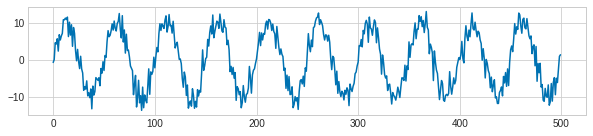

In [127]:
seq_len = 500

# Generating sample data
data = np.sin(np.linspace(0, 20*np.pi, seq_len))
data += np.random.normal(0, 0.2, size=seq_len)
data *= 10

plt.figure(figsize=(10, 2))
plt.plot(data)
plt.show()

In [128]:
def split_data(data, val_len, test_len):
    assert val_len > 0
    assert test_len > 0
    # Split lengths    
    train_value = {
        'T': data.shape[0] - val_len - test_len,
        'T_val': val_len,
        'T_test': test_len,
    }

    y = data.copy().reshape((-1, 1)) if data.ndim == 1 else data.copy()
    y_train, y_val, y_test = np.split(data, [-val_len-test_len, -test_len])
    if y_train.ndim == 1: y_train = y_train.reshape((-1, 1))
    if y_val.ndim == 1: y_val = y_val.reshape((-1, 1))
    if y_test.ndim == 1: y_test = y_test.reshape((-1, 1))
    return y, y_train, y_val, y_test, train_value

def standardize_data(y, y_train, y_val, y_test):
    scaler = preprocessing.StandardScaler()
    y_train_sc = scaler.fit_transform(y_train.reshape(-1,1))
    y_val_sc = scaler.transform(y_val.reshape(-1,1))
    y_test_sc = scaler.transform(y_test.reshape(-1,1))
    y_sc = scaler.transform(y.reshape(-1,1))

    return y_sc, y_train_sc, y_val_sc, y_test_sc, scaler

def transform_to_torch_tensor(y, y_train, y_val, y_test, y_sc, y_train_sc, y_val_sc, y_test_sc, train_value):
    T = train_value['T']
    T_val = train_value['T_val']
    T_test = train_value['T_test']

    y_train_sc = torch.FloatTensor(y_train_sc).reshape(1, T, y_train_sc.shape[1])
    y_val_sc = torch.FloatTensor(y_val_sc).reshape(1, T_val, y_test_sc.shape[1])
    y_test_sc = torch.FloatTensor(y_test_sc).reshape(1, T_test, y_test_sc.shape[1])
    y_sc = torch.FloatTensor(y_sc).reshape(1, y_sc.shape[0], y_sc.shape[1])
    y_train = torch.FloatTensor(y_train).reshape(1, T, y_train.shape[1])
    y_val = torch.FloatTensor(y_val).reshape(1, T_val, y_val.shape[1])
    y_test = torch.FloatTensor(y_test).reshape(1, T_test, y_test.shape[1])
    y = torch.FloatTensor(y).reshape(1, y.shape[0], y.shape[1])

    return y, y_train, y_val, y_test, y_sc, y_train_sc, y_val_sc, y_test_sc

In [129]:
y, y_train, y_val, y_test, train_value = split_data(data, 50, 50)
y_sc, y_train_sc, y_val_sc, y_test_sc, scaler = standardize_data(y, y_train, y_val, y_test)
(y_tensor, y_train_tensor, y_val_tensor, y_test_tensor,
 y_sc, y_train_sc, y_val_sc, y_test_sc) = transform_to_torch_tensor(
    y, y_train, y_val, y_test, y_sc, y_train_sc, y_val_sc, y_test_sc, train_value)

y_train.shape, y_val.shape, y_test.shape

((400, 1), (50, 1), (50, 1))

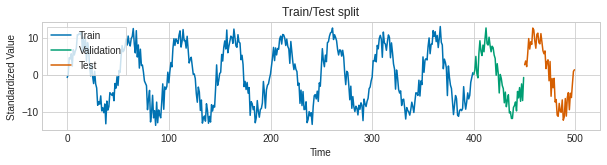

In [130]:
plt.figure(figsize=(10, 2))
plt.plot(np.arange(len(y_train)), y_train, label='Train')
plt.plot(np.arange(len(y_train), len(y_train)+len(y_val)), y_val, label='Validation')
plt.plot(np.arange(len(y_train)+len(y_val), len(y_train)+len(y_val)+len(y_test)), y_test, label='Test')
plt.legend(frameon=True, fancybox=False, loc='upper left')
plt.title('Train/Test split')
plt.xlabel('Time')
plt.ylabel('Standardized Value')
plt.show()

In [131]:
def plot_predictions(y_train, y_val, y_test, y_pred, y_025, y_975, train_value):

    T = train_value['T']
    T_val = train_value['T_val']
    T_test = train_value['T_test']
    T_pred = T + T_val + T_test

    x_train = np.arange(T)
    x_val = np.arange(T, T+T_val)
    x_test = np.arange(T+T_val, T_pred)
    x_pred = np.arange(T_pred)

    plt.figure(figsize=(10, 2))

    # Data
    plt.scatter(x_train, y_train, label='Train', color='k', s=5)
    plt.scatter(x_val, y_val, label='Val', color='c', s=5)
    plt.scatter(x_test, y_test, label='Test', color='b', s=5)
    # Predictions
    plt.plot(x_pred, y_pred, label='Prediction', color='r')
    plt.fill_between(x_pred, y_025, y_975, alpha=0.2, facecolor='r')
    # Windows
    plt.vlines([T, T+T_val], -10000, 10000, linestyles=':', color='k')
    plt.ylim(min([y_train.min(), y_val.min(), y_test.min(), y_pred.min()]) - 2,
             max([y_train.max(), y_val.max(), y_test.max(), y_pred.max()]) + 2)

    plt.legend(frameon=True, fancybox=False)
    plt.xlabel('Time')
    plt.ylabel('Value')

In [1]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, Predictive

In [133]:
class Emitter(nn.Module):
    """
    Parameterizes the bernoulli observation likelihood `p(x_t | z_t)`
    """

    def __init__(self, input_dim, z_dim, emission_dim):
        super(Emitter, self).__init__()
        # initialize the three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, emission_dim)
        self.lin_hidden_to_hidden = nn.Linear(emission_dim, emission_dim)
        self.lin_hidden_to_input_loc = nn.Linear(emission_dim, input_dim)
        # initialize the two non-linearities used in the neural network
        self.relu = nn.ReLU()

    def forward(self, z_t):
        """
        Given the latent z at a particular time step t we return the vector of
        probabilities `ps` that parameterizes the bernoulli distribution `p(x_t|z_t)`
        """
#         print("Emis_Zt, ", z_t.shape)
        h1 = self.relu(self.lin_z_to_hidden(z_t))
        h2 = self.relu(self.lin_hidden_to_hidden(h1))
        mu = self.lin_hidden_to_input_loc(h2)
#         print("Emis_MU, ", mu.shape)
        return mu

In [134]:
class GatedTransition(nn.Module):
    """
    Parameterizes the gaussian latent transition probability `p(z_t | z_{t-1})`
    See section 5 in the reference for comparison.
    """

    def __init__(self, z_dim, transition_dim):
        super(GatedTransition, self).__init__()
        # initialize the six linear transformations used in the neural network
        self.lin_gate_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_gate_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_proposed_mean_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_proposed_mean_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_sig = nn.Linear(z_dim, z_dim)
        self.lin_z_to_loc = nn.Linear(z_dim, z_dim)
        # modify the default initialization of lin_z_to_loc
        # so that it's starts out as the identity function
        self.lin_z_to_loc.weight.data = torch.eye(z_dim)
        self.lin_z_to_loc.bias.data = torch.zeros(z_dim)
        # initialize the three non-linearities used in the neural network
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        #self.batchnorm = nn.BatchNorm1d(num_features=transition_dim)

    def forward(self, z_t_1):
        """
        Given the latent `z_{t-1}` corresponding to the time step t-1
        we return the mean and scale vectors that parameterize the
        (diagonal) gaussian distribution `p(z_t | z_{t-1})`
        """
        # compute the gating function
        _gate = self.relu(self.lin_gate_z_to_hidden(z_t_1))
#         _gate = self.batchnorm(_gate)
        gate = torch.sigmoid(self.lin_gate_hidden_to_z(_gate))
        # compute the 'proposed mean'
        _proposed_mean = self.relu(self.lin_proposed_mean_z_to_hidden(z_t_1))
        proposed_mean = self.lin_proposed_mean_hidden_to_z(_proposed_mean)
        # assemble the actual mean used to sample z_t, which mixes a linear transformation
        # of z_{t-1} with the proposed mean modulated by the gating function
        loc = (1 - gate) * self.lin_z_to_loc(z_t_1) + gate * proposed_mean
        # compute the scale used to sample z_t, using the proposed mean from
        # above as input the softplus ensures that scale is positive
        scale = self.softplus(self.lin_sig(self.relu(proposed_mean)))
        # return loc, scale which can be fed into Normal
        return loc, scale

In [135]:
class Combiner(nn.Module):
    """
    Parameterizes `q(z_t | z_{t-1}, x_{t:T})`, which is the basic building block
    of the guide (i.e. the variational distribution). The dependence on `x_{t:T}` is
    through the hidden state of the RNN (see the PyTorch module `rnn` below)
    """

    def __init__(self, z_dim, rnn_dim):
        super(Combiner, self).__init__()
        # initialize the three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, rnn_dim)
        self.lin_hidden_to_loc = nn.Linear(rnn_dim, z_dim)
        self.lin_hidden_to_scale = nn.Linear(rnn_dim, z_dim)
        # initialize the two non-linearities used in the neural network
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1, h_rnn):
        """
        Given the latent z at at a particular time step t-1 as well as the hidden
        state of the RNN `h(x_{t:T})` we return the mean and scale vectors that
        parameterize the (diagonal) gaussian distribution `q(z_t | z_{t-1}, x_{t:T})`
        """
        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.lin_z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state to compute the mean used to sample z_t
        loc = self.lin_hidden_to_loc(h_combined)
        # use the combined hidden state to compute the scale used to sample z_t
        scale = self.softplus(self.lin_hidden_to_scale(h_combined))
        # return loc, scale which can be fed into Normal
        return loc, scale

In [136]:
class DKF(nn.Module):
    """
    This PyTorch Module encapsulates the model as well as the
    variational distribution (the guide) for the Deep Markov Model
    """

    def __init__(self, input_dim=1, z_dim=10, emission_dim=30,
                 transition_dim=30, rnn_dim=10, num_layers=1,
                 auto_scale=False, use_cuda=False, annealing_factor=1.0):

        super(DKF, self).__init__()

        # instantiate PyTorch modules used in the model and guide below
        self.emitter  = Emitter(input_dim, z_dim, emission_dim)
        self.trans    = GatedTransition(z_dim, transition_dim)
        self.combiner = Combiner(z_dim, rnn_dim)

        self.rnn = nn.RNN(input_size=input_dim,
                          hidden_size=rnn_dim,
                          nonlinearity="relu",
                          batch_first=True,
                          bidirectional=False,
                          num_layers=num_layers)

        # define a (trainable) parameters z_0 and z_q_0 that help define the probability
        # distributions p(z_1) and q(z_1)
        # (since for t = 1 there are no previous latents to condition on)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        self.sigma = nn.Parameter(torch.ones(input_dim)*0.3)
        # define a (trainable) parameter for the initial hidden state of the rnn
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))
        
        self.use_cuda = use_cuda
        self.annealing_factor = annealing_factor
        self.scaler = preprocessing.StandardScaler() if auto_scale else None
        # if on gpu cuda-ize all PyTorch (sub)modules
        if use_cuda: self.cuda()

    # the model p(x_{1:T} | z_{1:T}) p(z_{1:T})
    def model(self, sequence=None):  # modeling with prior distributions, p
        # get batch_size
        batch_size = len(sequence)
#         print("batch_size", batch_size)
        # this is the number of time steps we need to process in the mini-batch
        T_max = len(sequence[0]) if isinstance(sequence, list) else sequence.size(1)
        
        # register all PyTorch (sub)modules with pyro
        # this needs to happen in both the model and guide
        pyro.module("dkf", self)

        # set z_prev = z_0 to setup the recursive conditioning in p(z_t | z_{t-1})
        z_prev = self.z_0.expand(batch_size, self.z_0.size(0))
#         print("z_prev ", z_prev.shape)
        # we enclose all the sample statements in the model in a plate.
        # this marks that each datapoint is conditionally independent of the others
        with pyro.plate("data", batch_size):
            mus = torch.zeros((batch_size, T_max, 1))
            sigmas = torch.zeros((batch_size, T_max, 1))
            # sample the latents z and observed x's one time step at a time
            for t in range(1, T_max + 1):
                # the next chunk of code samples z_t ~ p(z_t | z_{t-1})
                # note that (both here and elsewhere) we use poutine.scale to take care
                # of KL annealing. we use the mask() method to deal with raggedness
                # in the observed data (i.e. different sequences in the mini-batch
                # have different lengths)

                # first compute the parameters of the diagonal gaussian distribution p(z_t | z_{t-1})
                z_loc, z_scale = self.trans(z_prev)
                
                # then sample z_t according to dist.Normal(z_loc, z_scale)
                # note that we use the reshape method so that the univariate Normal distribution
                # is treated as a multivariate Normal distribution with a diagonal covariance.
                with poutine.scale(scale=self.annealing_factor):
                    z_t = pyro.sample("z_%d" % t, dist.Normal(z_loc, z_scale).to_event(1))
                # print("z_t, ", z_t.shape)
                # compute the probabilities that parameterize the bernoulli likelihood
                emission_mu_t = self.emitter(z_t)
                # print("Mus, ", mus[:, t-1].shape)
                # print("Emis, ", emission_mu_t.shape)

                mus[:,t-1,:] = emission_mu_t
                # the next statement instructs pyro to observe x_t according to the
                # bernoulli distribution p(x_t|z_t)
                if isinstance(sequence, list):
                    pyro.sample("obs_y_%d" % t,
                        dist.Normal(loc=emission_mu_t, scale=self.sigma).to_event(1), obs=None)
                else:
                    pyro.sample("obs_y_%d" % t, 
                        dist.Normal(loc=emission_mu_t, scale=self.sigma).to_event(1), obs=sequence[:, t-1, :].view(-1))

                # the latent sampled at this time step will be conditioned upon
                # in the next time step so keep track of it
                z_prev = z_t

            return mus
    
    def guide(self, sequence=None):  # modeling with posterior distributions, q
        # get batch_size
        batch_size = len(sequence)
        # this is the number of time steps we need to process in the mini-batch
        T_max = len(sequence[0]) if isinstance(sequence, list) else sequence.size(1)
        # register all PyTorch (sub)modules with pyro
        pyro.module("dkf", self)
        # if on gpu we need the fully broadcast view of the rnn initial state
        # to be in contiguous gpu memory
        h_0_contig = self.h_0.expand(1, batch_size, self.rnn.hidden_size).contiguous()
        # push the observed x's through the rnn;
        # rnn_output contains the hidden state at each time step
        rnn_output, rnn_hidden_state = self.rnn(sequence, h_0_contig)
        
        # reverse rnn_output to get initial ordering
#         rnn_output = torch.flip(rnn_output[:, :, :], dims=[1])
    
        # set z_prev = z_q_0 to setup the recursive conditioning in q(z_t |...)
        z_prev = self.z_q_0.expand(batch_size, self.z_q_0.size(0))
        
        # we enclose all the sample statements in the guide in a plate.
        # this marks that each datapoint is conditionally independent of the others.
        with pyro.plate("data", batch_size):
            # sample the latents z one time step at a time
            for t in range(1, T_max + 1):
                # the next two lines assemble the distribution q(z_t | z_{t-1}, x_{t:T})
                z_loc, z_scale = self.combiner(z_prev, rnn_output[:, t - 1, :])
                
                z_dist = dist.Normal(z_loc, z_scale)
                assert z_dist.event_shape == ()
                assert z_dist.batch_shape == (batch_size, self.z_q_0.size(0))
                # sample z_t from the distribution z_dist
                with pyro.poutine.scale(scale=self.annealing_factor):
                # ".to_event(1)" indicates latent dimensions are independent
                    z_t = pyro.sample("z_%d" % t, z_dist.to_event(1))
                # the latent sampled at this time step will be conditioned upon in the next time step
                # so keep track of it
                z_prev = z_t

        def predict(self, ):
            return

        def forecast(self, forecast_steps, data=None):
            return

In [137]:
# Parameter initialization
pyro.clear_param_store()

# Model instance
dkf = DKF(z_dim=20, rnn_dim=50, emission_dim=30, transition_dim=30, annealing_factor=0.1)

optimizer = pyro.optim.PyroOptim(torch.optim.Adam, {'lr': 0.001})
svi = SVI(dkf.model, dkf.guide, optimizer, loss=Trace_ELBO())

Epoch 5/300, loss= 5.614, val_loss= 4.692, sigma= 1.357
Epoch 10/300, loss= 5.318, val_loss= 4.277, sigma= 1.363
Epoch 15/300, loss= 5.018, val_loss= 4.124, sigma= 1.370
Epoch 20/300, loss= 4.808, val_loss= 3.945, sigma= 1.377
Epoch 25/300, loss= 4.533, val_loss= 3.729, sigma= 1.383


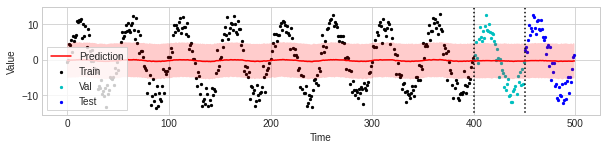

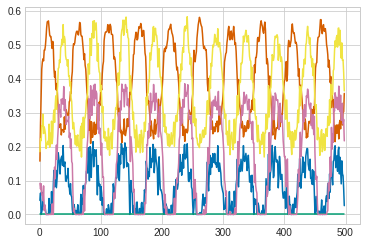

Epoch 30/300, loss= 4.294, val_loss= 3.260, sigma= 1.390
Epoch 35/300, loss= 3.770, val_loss= 2.828, sigma= 1.396
Epoch 40/300, loss= 2.833, val_loss= 2.064, sigma= 1.401
Epoch 45/300, loss= 2.155, val_loss= 1.540, sigma= 1.406
Epoch 50/300, loss= 1.755, val_loss= 1.337, sigma= 1.410


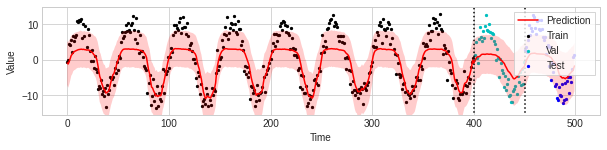

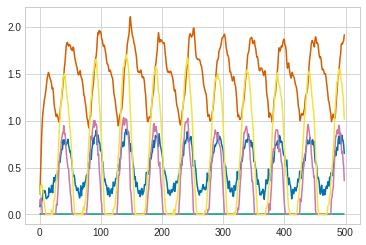

Epoch 55/300, loss= 1.346, val_loss= 1.108, sigma= 1.413
Epoch 60/300, loss= 1.126, val_loss= 1.115, sigma= 1.416
Epoch 65/300, loss= 0.808, val_loss= 0.810, sigma= 1.417
Epoch 70/300, loss= 0.700, val_loss= 0.676, sigma= 1.419
Epoch 75/300, loss= 0.586, val_loss= 0.805, sigma= 1.420


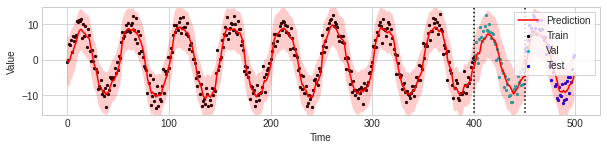

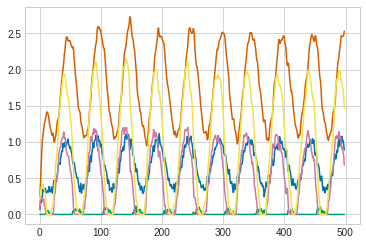

Epoch 80/300, loss= 0.600, val_loss= 0.544, sigma= 1.420
Epoch 85/300, loss= 0.479, val_loss= 0.639, sigma= 1.420
Epoch 90/300, loss= 0.559, val_loss= 0.497, sigma= 1.421
Epoch 95/300, loss= 0.470, val_loss= 0.442, sigma= 1.421
Epoch 100/300, loss= 0.428, val_loss= 0.580, sigma= 1.421


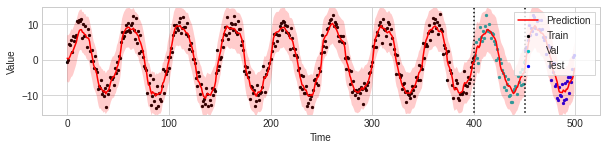

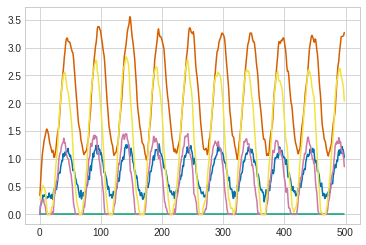

Epoch 105/300, loss= 0.467, val_loss= 0.668, sigma= 1.421
Epoch 110/300, loss= 0.433, val_loss= 0.460, sigma= 1.421
Epoch 115/300, loss= 0.418, val_loss= 0.307, sigma= 1.420
Epoch 120/300, loss= 0.391, val_loss= 0.548, sigma= 1.420
Epoch 125/300, loss= 0.372, val_loss= 0.358, sigma= 1.420


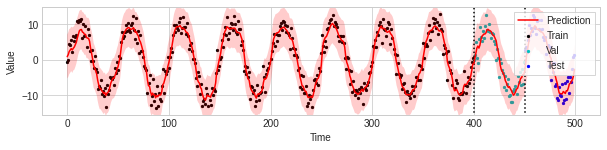

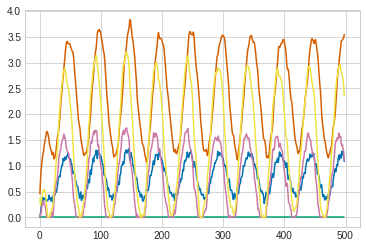

Epoch 130/300, loss= 0.432, val_loss= 0.517, sigma= 1.420
Epoch 135/300, loss= 0.365, val_loss= 0.430, sigma= 1.419
Epoch 140/300, loss= 0.354, val_loss= 0.457, sigma= 1.419
Epoch 145/300, loss= 0.343, val_loss= 0.471, sigma= 1.419
Epoch 150/300, loss= 0.341, val_loss= 0.330, sigma= 1.418


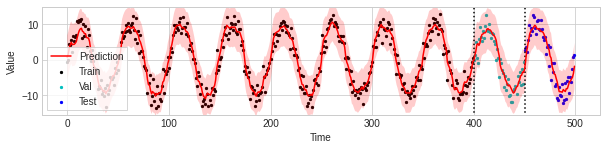

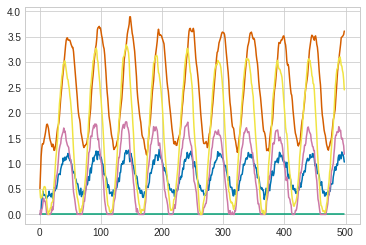

Epoch 155/300, loss= 0.351, val_loss= 0.449, sigma= 1.418
Epoch 160/300, loss= 0.293, val_loss= 0.280, sigma= 1.417
Epoch 165/300, loss= 0.332, val_loss= 0.276, sigma= 1.417
Epoch 170/300, loss= 0.324, val_loss= 0.354, sigma= 1.416
Epoch 175/300, loss= 0.314, val_loss= 0.283, sigma= 1.416


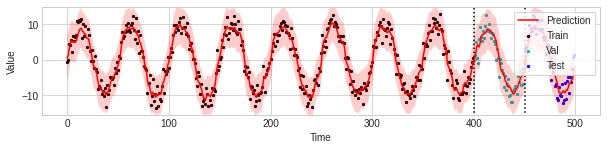

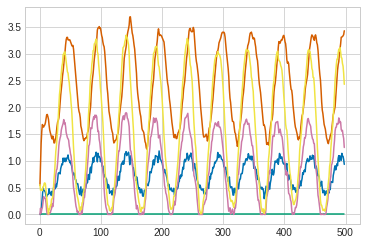

Epoch 180/300, loss= 0.294, val_loss= 0.290, sigma= 1.415
Epoch 185/300, loss= 0.275, val_loss= 0.294, sigma= 1.415
Epoch 190/300, loss= 0.272, val_loss= 0.366, sigma= 1.414
Epoch 195/300, loss= 0.290, val_loss= 0.350, sigma= 1.414
Epoch 200/300, loss= 0.297, val_loss= 0.341, sigma= 1.413


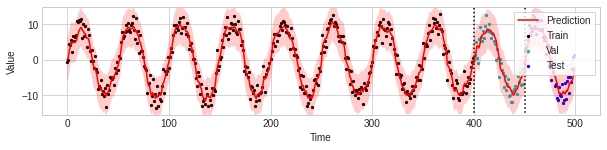

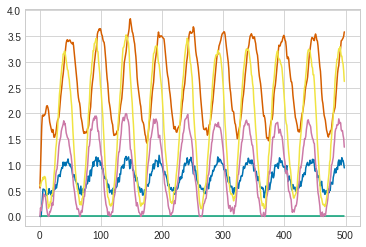

Epoch 205/300, loss= 0.280, val_loss= 0.246, sigma= 1.412
Epoch 210/300, loss= 0.285, val_loss= 0.358, sigma= 1.412
Epoch 215/300, loss= 0.278, val_loss= 0.310, sigma= 1.411
Epoch 220/300, loss= 0.260, val_loss= 0.226, sigma= 1.410
Epoch 225/300, loss= 0.228, val_loss= 0.272, sigma= 1.410


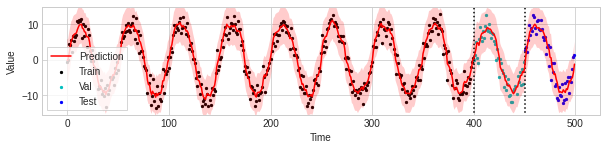

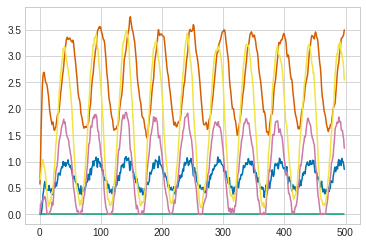

Epoch 230/300, loss= 0.257, val_loss= 0.258, sigma= 1.409
Epoch 235/300, loss= 0.265, val_loss= 0.354, sigma= 1.408
Epoch 240/300, loss= 0.252, val_loss= 0.214, sigma= 1.408
Epoch 245/300, loss= 0.251, val_loss= 0.344, sigma= 1.407
Epoch 250/300, loss= 0.262, val_loss= 0.227, sigma= 1.406


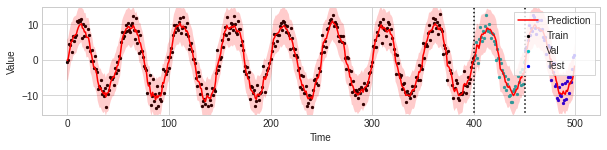

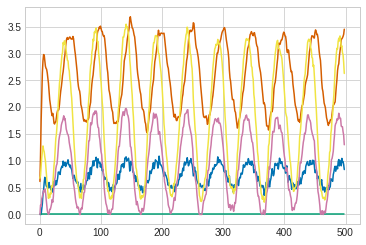

Epoch 255/300, loss= 0.246, val_loss= 0.210, sigma= 1.405
Epoch 260/300, loss= 0.251, val_loss= 0.152, sigma= 1.404
Epoch 265/300, loss= 0.211, val_loss= 0.196, sigma= 1.404
Epoch 270/300, loss= 0.223, val_loss= 0.182, sigma= 1.403
Epoch 275/300, loss= 0.230, val_loss= 0.205, sigma= 1.402


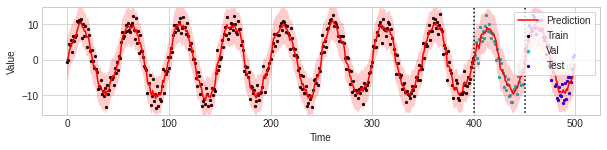

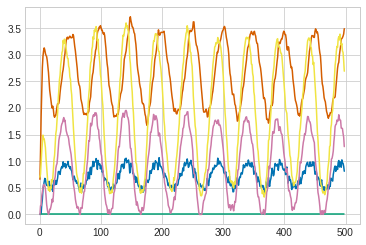

Epoch 280/300, loss= 0.210, val_loss= 0.223, sigma= 1.401
Epoch 285/300, loss= 0.225, val_loss= 0.197, sigma= 1.400
Epoch 290/300, loss= 0.221, val_loss= 0.255, sigma= 1.399
Epoch 295/300, loss= 0.202, val_loss= 0.190, sigma= 1.398
Epoch 300/300, loss= 0.209, val_loss= 0.204, sigma= 1.397


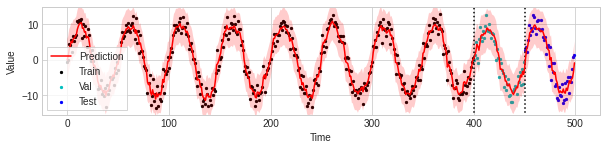

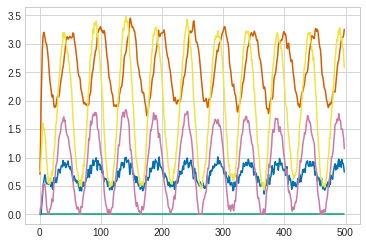

In [138]:
# Learning config
num_samples = 10000
num_epochs = 300
log_interval = 5
eval_interval = 5 * log_interval

T = len(y_train)
T_pred = len(y_val) + len(y_test)

for epoch in range(num_epochs):
    try:
        # single batch
        loss = svi.step(y_train_sc) / y_train_sc.size(1)
        val_loss = svi.evaluate_loss(y_val_sc) / y_val_sc.size(1)

        if epoch % log_interval == log_interval - 1:
            print('Epoch {}/{}, loss= {:.3f}, val_loss= {:.3f}, sigma= {:.3f}'.format(
                epoch+1, num_epochs, loss, val_loss, torch.exp(dkf.sigma).item()))

        if epoch % eval_interval == eval_interval - 1:
            # define initial hidden state
            h_0_contig = dkf.h_0.expand(1, 1, dkf.rnn.hidden_size).contiguous()

            # define num_latent samples
            num_latent_samples = 10000

            # Expand z_prev to have dimensions (num_latent_samples, latent_size)
            z_prev = dkf.z_0.expand(num_latent_samples, dkf.z_0.size(0))

            # book-keeping
            z_samples = []
            z_scales = [[], []]
            y_samples = []
            y_mean = []
            y_025 = []
            y_975 = []

            # Train Predictions
            rnn_output, rnn_hidden_state = dkf.rnn(y_sc[:, :T, :].float(), h_0_contig)

            # reverse rnn_output to get initial ordering
            #             rnn_output = torch.flip(rnn_output[:, :, :], dims=[1])

            rnn_output = rnn_output.expand(num_latent_samples, rnn_output.size(1), rnn_output.size(2))

            for t in range(T):
                # compute mean and variance of z_t
                z_loc, z_scale = dkf.combiner(z_prev, rnn_output[:, t, :])
                z_scales[0].append(z_scale.norm(dim=1).mean().item())
                z_scales[1].append(z_scale.norm(dim=1).std().item())
                # sample from z_t distribution
                z_t = dist.Normal(loc=z_loc, scale=z_scale).to_event(1).sample(sample_shape=[1]).reshape(z_prev.shape)
                if t != T-1:
                    z_samples.append(z_t)

                # compute mean of y_t
                y_loc = dkf.emitter(z_t).view(num_latent_samples, y_sc.size(2))

                # sample from y_t distribution
                y_t = dist.Normal(loc=y_loc, scale=dkf.sigma).to_event(1).sample(sample_shape=[1]).view(num_latent_samples, y_sc.size(2)).detach().numpy()
                y_samples.append(y_t)

                # store z_t for next computation
                if t != T-1:
                    z_prev = z_samples[-1]

                # store predictions and CI
                y_mean.append(np.mean(y_t, axis=0))
                y_025.append(np.quantile(a=y_t, q=0.025, axis=0))
                y_975.append(np.quantile(a=y_t, q=0.975, axis=0))

            # Test Predictions
            for t in range(T, T + T_pred):
                rnn_output, rnn_hidden_state = dkf.rnn(y_sc[:, :t, :].float(), h_0_contig)

                rnn_output = rnn_output.expand(num_latent_samples, rnn_output.size(1), rnn_output.size(2))

                # compute mean and variance of z_t_1
                z_loc, z_scale = dkf.combiner(z_samples[-1], rnn_output[:, -1, :])
                z_scales[0].append(z_scale.norm(dim=1).mean().item())
                z_scales[1].append(z_scale.norm(dim=1).std().item())
                
                # sample from z_t_1 distribution
                z_t_1 = dist.Normal(loc=z_loc, scale=z_scale).to_event(1).sample(sample_shape=[1]).reshape(z_prev.shape)
                z_samples.append(z_t_1)

                # run transition network forward
                z_t_loc, z_t_scale = dkf.trans(z_t_1)
                
                z_t = dist.Normal(loc=z_t_loc, scale=z_t_scale).to_event(1).sample(sample_shape=[1]).reshape(z_prev.shape)

                # compute mean of y_t
                y_loc = dkf.emitter(z_t).view(num_latent_samples, y_sc.size(2))

                # sample from y_t distribution
                y_t = dist.Normal(loc=y_loc, scale=dkf.sigma).to_event(1).sample(sample_shape=[1]).view(num_latent_samples, y_sc.size(2)).detach().numpy()
                y_samples.append(y_t)

                # store predictions and CI
                y_mean.append(np.mean(y_t, axis=0))
                y_025.append(np.quantile(a=y_t, q=0.025, axis=0))
                y_975.append(np.quantile(a=y_t, q=0.975, axis=0))

            # compute predictions
            # y_pred = np.array(y_mean)
            # y_025 = np.array(y_025)
            # y_975 = np.array(y_975)
            y_pred = scaler.inverse_transform(np.array(y_mean))
            y_025 = scaler.inverse_transform(np.array(y_025))
            y_975 = scaler.inverse_transform(np.array(y_975))

            plot_predictions(y_train, y_val, y_test,
                 y_pred, y_025[:, 0], y_975[:, 0], train_value)
            plt.show()

            plt.plot(rnn_output.detach().numpy()[0, :, :5])
            plt.show()

    except KeyboardInterrupt:
        break